In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import torch 
device = torch.device('cpu')
device

device(type='cpu')

# Import Data

In [3]:
import torchvision

In [4]:
from torchvision import datasets, transforms
from torchvision.transforms import v2

from torch.utils.data import DataLoader

In [5]:
transform = v2.Compose([
    v2.Resize((32, 32)),
    v2.ToImage(), 
    v2.ToDtype(torch.float32, True)
])

In [6]:
trainset = datasets.EMNIST('data', split='letters', download=True, transform=transform, train=True)
testset = datasets.EMNIST('data', split='letters', download=True, transform=transform, train=False)

In [7]:
trainloader = DataLoader(trainset, batch_size=256, shuffle=True, drop_last=True)
testloader  = DataLoader(testset, batch_size=256, shuffle=True, drop_last=True)

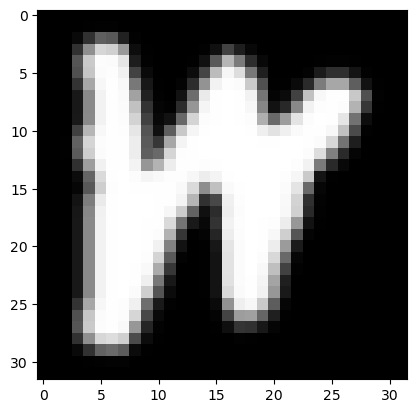

In [8]:
plt.imshow(trainset[0][0].permute(2, 1, 0), cmap=plt.cm.Grays_r);

In [9]:
len(trainset)#, len(testset)

124800

# Modeling

In [10]:
import torch
from torch import nn, optim 
from torch.nn import functional as F
from torch.autograd import Variable

import math

In [11]:
class MainModel(nn.Module): 
    def __init__(self, num_class, input_size):
        super().__init__()

        self.input_size = input_size
        self.fc = nn.Sequential(
            nn.Linear(32 * 32, 256), 
            nn.Tanh(),
            nn.Linear(256, 64),
            nn.Tanh(),
            nn.Linear(64, num_class),
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.fc(x)

# Parameter Tuning

In [12]:
def cross_entropy_loss(y_pred, y_true, ignore_index = 1):
    y_pred = y_pred.transpose(2, 1)
    batch_size, sequence_length, num_class = y_pred.shape

    y_true_one_hot = F.one_hot(y_true, num_class) 
    if ignore_index > -1: 
        # buat label menjadi bernilai 0
        y_true_one_hot[:, :, ignore_index] = 0

    loss = - torch.sum(y_true_one_hot * torch.log(y_pred.softmax(-1)), dim=-1)
    return loss[ loss != -0 ].mean()

- Blog : [Log Sum Trick](https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/) <br>
- Youtube : [Log Sum Trick: Anak AI](https://www.youtube.com/watch?v=gJ6pwxv72pw) <br>

In [13]:
def cross_entropy_loss(y_pred, y_true, ignore_index = -1):
    # y_pred = y_pred.transpose(2, 1)
    batch_size, num_class = y_pred.size(0), y_pred.size(1)

    y_true_one_hot = F.one_hot(y_true, num_class) 
    if ignore_index > -1: 
        # label menjadi bernilai 0 pada index yang di abaikan
        y_true_one_hot[:, ignore_index] = 0
        mask = y_true_one_hot.sum(dim=-1, keepdim=True)

    constant = y_pred.max(dim = -1).values.unsqueeze(-1)

    # mengatasi overflow pada exponensial jika nilai logits terlalu besar
    a = - torch.sum(y_true_one_hot * y_pred, dim=-1, keepdim=True) 
    b = torch.sum(torch.exp(y_pred - constant), dim=-1, keepdim=True).log()
    loss = a + constant + b
    
    loss = loss * mask if ignore_index > -1 else loss

    return loss[ loss != 0 ].mean()

In [14]:
def log_softmax(tensor): 
    constant = tensor.max(dim=-1, keepdim=True).values
    a = torch.sum(torch.exp( tensor - constant ), dim=-1, keepdim=True).log()
    log_sum_trick = constant + a
    return tensor - log_sum_trick

In [15]:
sample = torch.Tensor([1,0,1,0])

In [16]:
sample = sample.masked_fill(sample == 0, 0.1)

In [17]:
sample

tensor([1.0000, 0.1000, 1.0000, 0.1000])

Blog : 
- [Label Smoothing: Blog](https://medium.com/towards-data-science/what-is-label-smoothing-108debd7ef06)

Paper : <br>
- [When Does Label Smoothing Help?](https://arxiv.org/pdf/1906.02629)
- [Delving Deep into Label Smoothing: Preliminary](https://arxiv.org/pdf/2011.12562)

In [18]:
def nll_loss_n_log_softmax(y_pred, y_true, ignore_index = -1, label_smoothing=0.0):
    batch_size, num_class = y_pred.size(0), y_pred.size(1)

    y_true_one_hot = F.one_hot(y_true, num_class).to(torch.float32)

    if label_smoothing > 0 : 
        y_true_one_hot = (1 - label_smoothing) * y_true_one_hot + label_smoothing / num_class
        
    
    y_pred = log_softmax(y_pred) # log softmax activation function

    if ignore_index > -1:
        y_true_one_hot[:, ignore_index] = 0
        # mask = y_true_one_hot.sum(dim=-1, keepdim=True)

    loss = - torch.sum(y_true_one_hot * y_pred, dim=-1)
    return loss[ loss != 0].mean() # reduction + ignore value 0 | ignore index

In [23]:
model = MainModel(len(trainset.classes), 32 * 32)
# index 0 adalah index untuk token <PAD>
# criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
criterion = nll_loss_n_log_softmax
optimizer = optim.Adam(model.parameters(), lr=0.001)

ERROR! Session/line number was not unique in database. History logging moved to new session 179


In [24]:
for source, target in trainloader:

    predict = model(source)
    print(predict.shape, target.shape)

    # loss = cross_entropy_loss(predict, target)
    # print(loss)
    loss = criterion(predict, target)
    print(loss)
    loss = nn.functional.cross_entropy(predict, target)
    print(loss)
    
    break 

torch.Size([256, 27]) torch.Size([256])
tensor(3.3192, grad_fn=<MeanBackward0>)
tensor(3.3192, grad_fn=<NllLossBackward0>)


# Training

In [25]:
from tqdm import tqdm

In [26]:
total_epoch = 20
train_cost = [] 
test_cost  = []

In [27]:
cost_min = 10
# patience = 0
# max_patience = 3

for epoch in range(total_epoch):

    print(f'Epoch: {epoch + 1}')
    
    cost = 0 
    model.train()
    with tqdm(trainloader) as pbar:
        for indices, (feature, target) in enumerate(pbar, start=1):
        
            pred = model(feature)
            loss = criterion(pred, target)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            cost += loss.item()
            pbar.set_postfix(loss=loss.item(), cost=cost/indices)

    train_cost.append(cost / indices)

    cost = 0
    model.eval()
    with torch.no_grad():
        pbar = tqdm(testloader)
        for indices, (feature, target) in enumerate(pbar, start=1):
        
            pred = model(feature)
            loss = criterion(pred, target)
        
            cost += loss.item()
            pbar.set_postfix(loss=loss.item(), cost=cost/indices)

    
    test_cost.append(cost / indices)

Epoch: 1


100%|██████████████████████████████████████████████████████████| 81/81 [00:10<00:00,  7.73it/s, cost=0.583, loss=0.535]


Epoch: 2


100%|██████████████████████████████████████████████████████████| 81/81 [00:10<00:00,  7.86it/s, cost=0.416, loss=0.455]


Epoch: 3


100%|███████████████████████████████████████████████████████████| 81/81 [00:10<00:00,  7.86it/s, cost=0.35, loss=0.277]


Epoch: 4


100%|██████████████████████████████████████████████████████████| 81/81 [00:10<00:00,  7.78it/s, cost=0.325, loss=0.298]


Epoch: 5


100%|███████████████████████████████████████████████████████████| 81/81 [00:10<00:00,  7.84it/s, cost=0.32, loss=0.235]


Epoch: 6


100%|███████████████████████████████████████████████████████████| 81/81 [00:12<00:00,  6.28it/s, cost=0.31, loss=0.341]


Epoch: 7


100%|██████████████████████████████████████████████████████████| 81/81 [00:10<00:00,  7.88it/s, cost=0.303, loss=0.225]


Epoch: 8


100%|██████████████████████████████████████████████████████████| 81/81 [00:10<00:00,  7.45it/s, cost=0.304, loss=0.371]


Epoch: 9


100%|██████████████████████████████████████████████████████████| 81/81 [00:11<00:00,  7.31it/s, cost=0.301, loss=0.393]


Epoch: 10


100%|██████████████████████████████████████████████████████████| 81/81 [00:10<00:00,  7.65it/s, cost=0.305, loss=0.214]


Epoch: 11


100%|██████████████████████████████████████████████████████████| 81/81 [00:10<00:00,  7.82it/s, cost=0.308, loss=0.347]


Epoch: 12


100%|███████████████████████████████████████████████████████████| 81/81 [00:10<00:00,  7.82it/s, cost=0.315, loss=0.36]


Epoch: 13


100%|███████████████████████████████████████████████████████████| 81/81 [00:10<00:00,  7.43it/s, cost=0.311, loss=0.36]


Epoch: 14


100%|███████████████████████████████████████████████████████████| 81/81 [00:13<00:00,  6.21it/s, cost=0.31, loss=0.357]


Epoch: 15


100%|██████████████████████████████████████████████████████████| 81/81 [00:10<00:00,  7.71it/s, cost=0.315, loss=0.273]


Epoch: 16


100%|███████████████████████████████████████████████████████████| 81/81 [00:10<00:00,  7.59it/s, cost=0.325, loss=0.33]


Epoch: 17


100%|██████████████████████████████████████████████████████████| 81/81 [00:13<00:00,  6.22it/s, cost=0.333, loss=0.403]


Epoch: 18


100%|██████████████████████████████████████████████████████████| 81/81 [00:10<00:00,  7.74it/s, cost=0.329, loss=0.249]


Epoch: 19


100%|██████████████████████████████████████████████████████████| 81/81 [00:13<00:00,  6.04it/s, cost=0.333, loss=0.343]


Epoch: 20


100%|██████████████████████████████████████████████████████████| 81/81 [00:11<00:00,  7.32it/s, cost=0.342, loss=0.436]


# Plot Loss

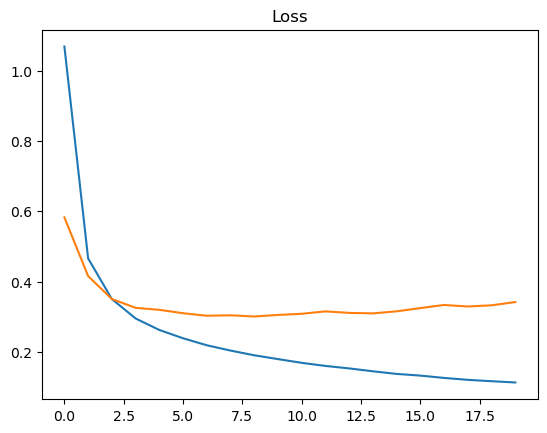

In [28]:
plt.plot(train_cost)
plt.plot(test_cost)
plt.title('Loss');